In [1]:
import numpy as np
import lsst.sims.featureScheduler as fs
from lsst.sims.speedObservatory import Speed_observatory
import matplotlib.pylab as plt
import healpy as hp
import time
import matplotlib.pylab as plt
%matplotlib inline
from vary_exptime import Vary_expt_survey

/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/utils.py:27: UserWarning: Could not import ts.scheduler. This is required to load the FieldsDatabase. In this case
it will fallback to loading fields from the local "fieldID.lis" file.
  it will fallback to loading fields from the local "fieldID.lis" file.''')


In [2]:
survey_length = 5.#365.25*2.01 # 365.25*10  # days
nside = fs.set_default_nside(nside=32)
years = np.round(survey_length/365.25)
t0 = time.time()

In [3]:
target_map = fs.standard_goals(nside=nside)
norm_factor = fs.calc_norm_factor(target_map)

# let's get a narrow dec band, just for fun


In [4]:
# Set up observations to be taken in blocks
surveys = []
filter1s = ['r'] #['u', 'g', 'r', 'i', 'z', 'y']
filter2s = [None] #[None, 'g', 'r', 'i', None, None]
pair_surveys = []
for filtername, filtername2 in zip(filter1s, filter2s):
    bfs = []
    bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    if filtername2 is not None:
        bfs.append(fs.M5_diff_basis_function(filtername=filtername2, nside=nside))
    bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                            target_map=target_map[filtername],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside,
                                            norm_factor=norm_factor))
    if filtername2 is not None:
        bfs.append(fs.Target_map_basis_function(filtername=filtername2,
                                                target_map=target_map[filtername2],
                                                out_of_bounds_val=hp.UNSEEN, nside=nside,
                                                norm_factor=norm_factor))
    bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Strict_filter_basis_function(filtername=filtername))
    bfs.append(fs.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=90.))
    weights = np.array([3.0, 3.0, .3, .3, 3., 3., 0.])
    if filtername2 is None:
        # Need to scale weights up so filter balancing still works properly.
        weights = np.array([6.0, 0.6, 3., 3., 0.])
    
    if filtername2 is None:
        survey_name = 'blob, %s' % filtername
    else:
        survey_name = 'blob, %s%s' % (filtername, filtername2)
    surveys.append(Vary_expt_survey(bfs, weights, filtername=filtername,
                                       filter2=filtername2,
                                       survey_note=survey_name))
    pair_surveys.append(surveys[-1])


In [5]:
filters = ['i', 'z', 'y']
greedy_surveys = []
for filtername in filters:
    bfs = []
    bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                            target_map=target_map[filtername],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside,
                                            norm_factor=norm_factor))

    bfs.append(fs.North_south_patch_basis_function(zenith_min_alt=50., nside=nside))
    bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Strict_filter_basis_function(filtername=filtername))

    weights = np.array([3.0, 0.3, 1., 3., 3.])
    # Might want to try ignoring DD observations here, so the DD area gets covered normally--DONE
    surveys.append(fs.Greedy_survey_fields(bfs, weights, block_size=1, filtername=filtername,
                                           dither=True, nside=nside, ignore_obs='DD'))
    greedy_surveys.append(surveys[-1])


In [6]:
survey_list_o_lists = [pair_surveys, greedy_surveys]

In [7]:
scheduler = fs.Core_scheduler(survey_list_o_lists, nside=nside)
n_visit_limit = None
observatory = Speed_observatory(nside=nside, quickTest=True)
observatory, scheduler, observations = fs.sim_runner(observatory, scheduler,
                                                     survey_length=survey_length,
                                                     filename='rolling_%iyrs.db' % years,
                                                     delete_past=True, n_visit_limit=n_visit_limit)
t1 = time.time()
delta_t = t1-t0
print('ran in %.1f min = %.1f hours' % (delta_t/60., delta_t/3600.))


/Users/yoachim/gitRepos/sims_seeingModel/python/lsst/sims/seeingModel/seeingModel.py:133: RuntimeWarning: invalid value encountered in power
  airmass_correction = np.power(airmass, 0.6)


progress = 100.2%Skipped 0 observations
Completed 3987 observations
ran in 3.2 min = 0.1 hours


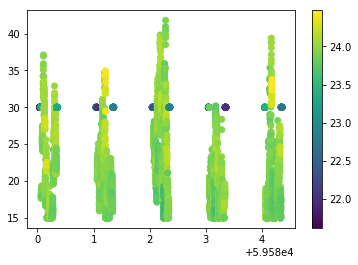

In [8]:
plt.scatter(observations['mjd'], observations['exptime'], c=observations['fivesigmadepth'])
cb = plt.colorbar()

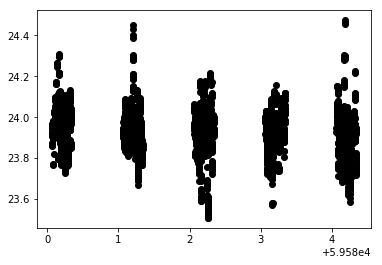

In [9]:
#good = np.where((observations['exptime'] != 30.) & ( observations['exptime'] != 15.))
good=np.where(observations['note'] != '')
plt.plot(observations['mjd'][good], observations['fivesigmadepth'][good], 'ko')

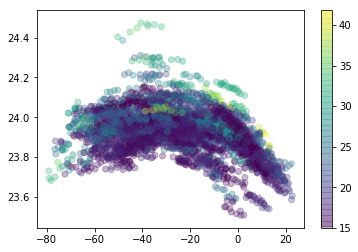

In [10]:
# Fuck, oh right, this is at a given spot.
plt.scatter(observations['dec'][good], observations['fivesigmadepth'][good],
            c=observations['exptime'][good], alpha=.3)
cb = plt.colorbar()

In [11]:
# OK, let's try the same thing put with the regular blob survey:
# Set up observations to be taken in blocks
surveys = []
filter1s = ['r'] #['u', 'g', 'r', 'i', 'z', 'y']
filter2s = [None] #[None, 'g', 'r', 'i', None, None]
pair_surveys = []
for filtername, filtername2 in zip(filter1s, filter2s):
    bfs = []
    bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    if filtername2 is not None:
        bfs.append(fs.M5_diff_basis_function(filtername=filtername2, nside=nside))
    bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                            target_map=target_map[filtername],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside,
                                            norm_factor=norm_factor))
    if filtername2 is not None:
        bfs.append(fs.Target_map_basis_function(filtername=filtername2,
                                                target_map=target_map[filtername2],
                                                out_of_bounds_val=hp.UNSEEN, nside=nside,
                                                norm_factor=norm_factor))
    bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Strict_filter_basis_function(filtername=filtername))
    bfs.append(fs.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=90.))
    weights = np.array([3.0, 3.0, .3, .3, 3., 3., 0.])
    if filtername2 is None:
        # Need to scale weights up so filter balancing still works properly.
        weights = np.array([6.0, 0.6, 3., 3., 0.])
    
    if filtername2 is None:
        survey_name = 'blob, %s' % filtername
    else:
        survey_name = 'blob, %s%s' % (filtername, filtername2)
    surveys.append(fs.Blob_survey(bfs, weights, filtername=filtername,
                                       filter2=filtername2,
                                       survey_note=survey_name))
    pair_surveys.append(surveys[-1])


In [12]:
filters = ['i', 'z', 'y']
greedy_surveys = []
for filtername in filters:
    bfs = []
    bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                            target_map=target_map[filtername],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside,
                                            norm_factor=norm_factor))

    bfs.append(fs.North_south_patch_basis_function(zenith_min_alt=50., nside=nside))
    bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Strict_filter_basis_function(filtername=filtername))

    weights = np.array([3.0, 0.3, 1., 3., 3.])
    # Might want to try ignoring DD observations here, so the DD area gets covered normally--DONE
    surveys.append(fs.Greedy_survey_fields(bfs, weights, block_size=1, filtername=filtername,
                                           dither=True, nside=nside, ignore_obs='DD'))
    greedy_surveys.append(surveys[-1])


In [13]:
survey_list_o_lists = [pair_surveys, greedy_surveys]

In [14]:
scheduler = fs.Core_scheduler(survey_list_o_lists, nside=nside)
n_visit_limit = None
observatory = Speed_observatory(nside=nside, quickTest=True)
observatory, scheduler, observations = fs.sim_runner(observatory, scheduler,
                                                     survey_length=survey_length,
                                                     filename='rolling_%iyrs.db' % years,
                                                     delete_past=True, n_visit_limit=n_visit_limit)
t1 = time.time()
delta_t = t1-t0
print('ran in %.1f min = %.1f hours' % (delta_t/60., delta_t/3600.))


/Users/yoachim/gitRepos/sims_seeingModel/python/lsst/sims/seeingModel/seeingModel.py:133: RuntimeWarning: invalid value encountered in power
  airmass_correction = np.power(airmass, 0.6)


progress = 100.2%Skipped 0 observations
Completed 3148 observations
ran in 5.8 min = 0.1 hours


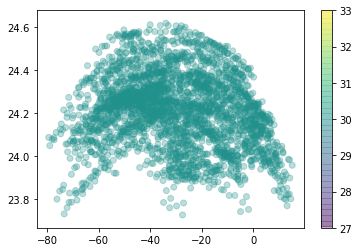

In [15]:
# Fuck, oh right, this is at a given spot.
good=np.where(observations['note'] != '')
plt.scatter(observations['dec'][good], observations['fivesigmadepth'][good],
            c=observations['exptime'][good], alpha=.3)
cb = plt.colorbar()